# Predicting March Madness winners using automated feature engineering and head to head information

In [1]:
#this is my standard way of handling path issues and shared libraries with Jupyter Notebooks
#Basically just set the path using the folder_name of the project and create any env variables
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
sys.path.insert(0, DATA_ROOT)

import utils
#use reload to easily reload changes
from importlib import reload
_=reload(utils)
import pandas as pd
np=pd.np
pd.options.display.max_rows=10#So we don't have to always write head
pd.options.display.max_columns=999
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import featuretools as ft
ft.__version__

'0.6.1'

# Load Data

First build team game logs as the base for building the matchups and team_game entiysets

In [2]:
reload(utils)
team_game_log=utils.build_team_game_log()
team_game_log

season  DayNum  team_TeamID  team_Score  opp_TeamID  opp_Score  NumOT  \
0         2003      10         1104          68        1328         62      0   
1         2003      10         1328          62        1104         68      0   
2         2003      10         1272          70        1393         63      0   
3         2003      10         1393          63        1272         70      0   
4         2003      11         1186          55        1458         81      0   
...        ...     ...          ...         ...         ...        ...    ...   
177099    2019     132         1463          97        1217         85      0   
177100    2019     132         1276          60        1277         65      0   
177101    2019     132         1277          65        1276         60      0   
177102    2019     132         1382          53        1387         55      0   
177103    2019     132         1387          55        1382         53      0   

        team_FGM  team_FGA  team_FGM3  team_FGA3  team_FTM  team_FTA  team_OR  \
0             27        58          3         14        11        18       14   
1             22        53          2         10        16        22       10   
2             26        62          8         20        10        19       15   
3             24        67          6         24         9        20       20   
4             20        46          3         11        12        17        6   
...          ...       ...        ...        ...       ...       ...      ...   
177099        32        53          5         11        28        30        6   
177100        21        51          8         25        10        12        3   
177101        22        55          9         23        12        16       11   
177102        19        56          7         19         8        10       13   
177103        22        59          4         22         7        15       15   

        team_DR  team_Ast  team_TO  team_Stl  team_Blk  team_PF  opp_FGM  \
0            24        13       23         7         1       22       22   
1            22         8       18         9         2       20       27   
2            28        16       13         4         4       18       24   
3            25         7       12         8         6       16       26   
4            22         8       19         4         3       25       26   
...         ...       ...      ...       ...       ...      ...      ...   
177099       23        11        7         4         5       18       28   
177100       26        17        6         5         5       11       22   
177101       27        14        9         2         6       10       21   
177102       30         9       11         2         7       16       22   
177103       25        13        6         6         8       11       19   

        opp_FGA  opp_FGM3  opp_FGA3  opp_FTM  opp_FTA  opp_OR  opp_DR  \
0            53         2        10       16       22      10      22   
1            58         3        14       11       18      14      24   
2            67         6        24        9       20      20      25   
3            62         8        20       10       19      15      28   
4            57         6        12       23       27      12      24   
...         ...       ...       ...      ...      ...     ...     ...   
177099       62        10        32       19       24      12      15   
177100       55         9        23       12       16      11      27   
177101       51         8        25       10       12       3      26   
177102       59         4        22        7       15      15      25   
177103       56         7        19        8       10      13      30   

        opp_Ast  opp_TO  opp_Stl  opp_Blk  opp_PF       game_type  \
0             8      18        9        2      20  regular_season   
1            13      23        7        1      22  regular_season   
2             7      12        8        6      16  regular_season

In [3]:
matchups_es=utils.load_matchups_entityset(team_game_log)
matchups_es

Entityset: None
  Entities:
    possible_matchups [Rows: 66795, Columns: 3]
    matchup_log [Rows: 88552, Columns: 126]
  Relationships:
    matchup_log.matchup_id -> possible_matchups.matchup_id

For all the statistics below see https://www.basketball-reference.com/about/glossary.html for an idea about names if you are unsure of the abbreviations

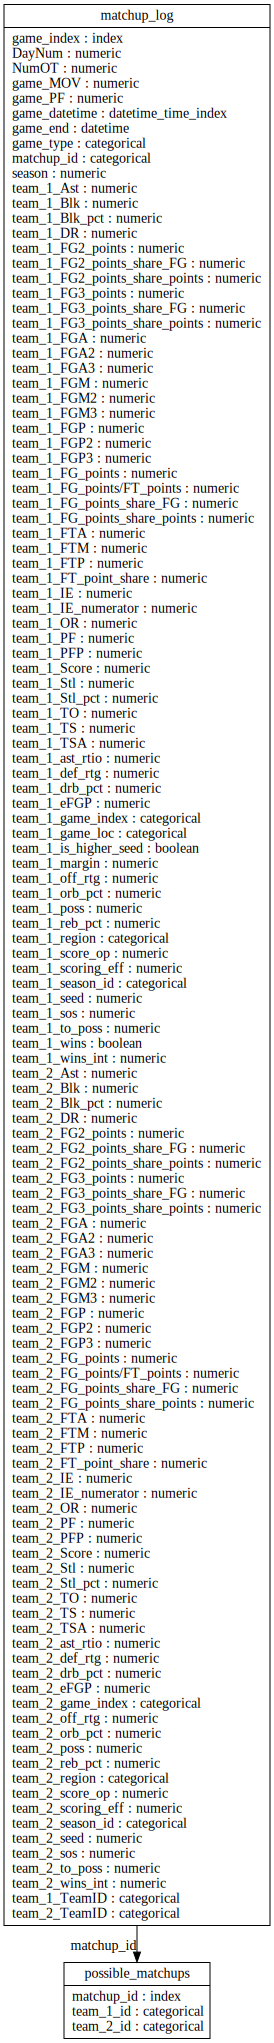

In [4]:
matchups_es.plot()

In [5]:
reload(utils)
team_game_logs_es=utils.load_team_game_logs_entityset(team_game_log)
team_game_logs_es

Entityset: None
  Entities:
    team [Rows: 366, Columns: 4]
    team_game_log [Rows: 177104, Columns: 128]
  Relationships:
    team_game_log.team_TeamID -> team.TeamID

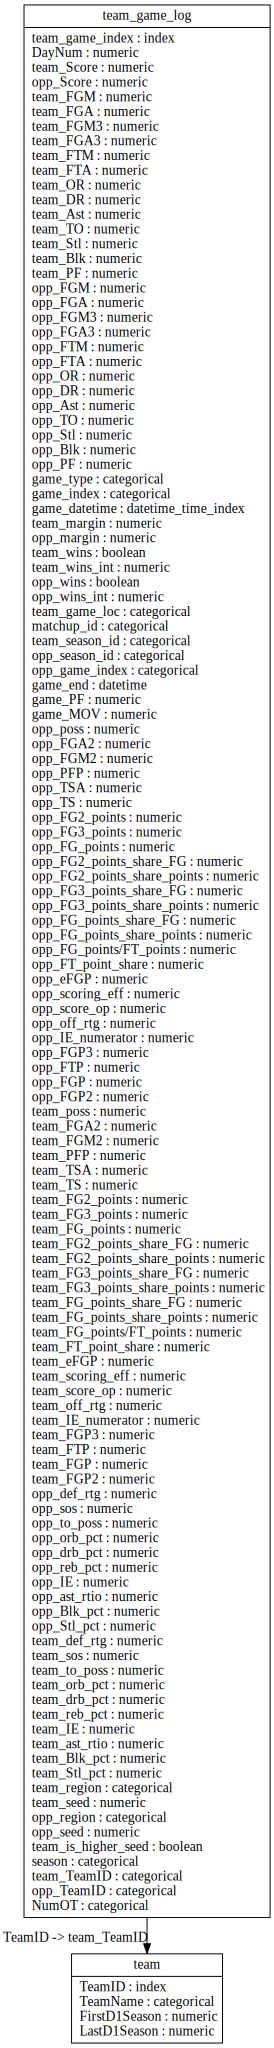

In [6]:
team_game_logs_es.plot()

In [7]:
massey = pd.read_csv(DATA_ROOT + "/MasseyOrdinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv",engine="python")

In [81]:
sorted(massey['SystemName'].unique())

['7OT',
 'ACU',
 'ADE',
 'AP',
 'ARG',
 'AUS',
 'AWS',
 'BBT',
 'BCM',
 'BD',
 'BIH',
 'BKM',
 'BLS',
 'BNM',
 'BNT',
 'BOB',
 'BOW',
 'BP5',
 'BPI',
 'BRZ',
 'BUR',
 'BWE',
 'CJB',
 'CMV',
 'CNG',
 'COL',
 'COX',
 'CPA',
 'CPR',
 'CRO',
 'CRW',
 'CTL',
 'D1A',
 'DAV',
 'DC',
 'DC2',
 'DCI',
 'DDB',
 'DES',
 'DII',
 'DOK',
 'DOL',
 'DUN',
 'DWH',
 'EBB',
 'EBP',
 'ECK',
 'ENT',
 'ERD',
 'ESR',
 'FAS',
 'FMG',
 'FSH',
 'GC',
 'GRN',
 'GRS',
 'HAS',
 'HAT',
 'HER',
 'HKB',
 'HKS',
 'HOL',
 'HRN',
 'IMS',
 'INC',
 'INP',
 'ISR',
 'JCI',
 'JEN',
 'JJK',
 'JNG',
 'JON',
 'JRT',
 'KBM',
 'KEL',
 'KLK',
 'KMV',
 'KOS',
 'KPI',
 'KPK',
 'KRA',
 'LAB',
 'LAW',
 'LEF',
 'LMC',
 'LOG',
 'LYD',
 'LYN',
 'MAS',
 'MB',
 'MCL',
 'MGS',
 'MGY',
 'MIC',
 'MKV',
 'MMG',
 'MOR',
 'MPI',
 'MSX',
 'MUZ',
 'MvG',
 'NET',
 'NOL',
 'NOR',
 'OCT',
 'OMY',
 'PEQ',
 'PGH',
 'PH',
 'PIG',
 'PIR',
 'PKL',
 'PMC',
 'POM',
 'PPR',
 'PRR',
 'PTS',
 'RAG',
 'REI',
 'REN',
 'REW',
 'RIS',
 'RM',
 'ROG',
 'ROH',
 'RPI',

In [8]:
import datetime
seasons=utils.seasons
def get_game_daytime(row):
    # DayNum is days since season start
    game_day = seasons.loc[row['Season']]['DayZero'] + datetime.timedelta(days=row['RankingDayNum'])
    return game_day

In [154]:
massey = pd.read_csv(DATA_ROOT + "/MasseyOrdinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv",engine="python")
use_systems=["SAG","POM","NET","DOK","SPR","AP","WOB"]
systems=massey[(massey['SystemName'].isin(use_systems))]
#systems['game_datetime']=systems.apply(get_game_daytime,axis=1)

In [10]:
system=systems[systems['SystemName']=='SAG']
system['OrdinalRank'].max()

353

In [116]:
from scipy.stats import logistic
N=353
def rating_mapping(rank):
    N=353
    percent_diff=(N-rank)/(N)
    percent_diff=np.clip(percent_diff,.05,.99)
    print(percent_diff)
    return logistic.ppf(percent_diff,scale=50)

def tourney_rating_mapping(rank):
    N=64
    percent_diff=(N-rank)/(N)
    percent_diff=np.clip(percent_diff,.10,.90)
    return logistic.ppf(percent_diff,scale=100)

def predict_prob(rank1,rank2):
    E_1 = 1./(1 + 10 ** ((rank2 - rank1) / (320.)))
    return E_1
ranks=[1,10,150,353]
ratings=list(map(rating_mapping,
                ranks))
predict_prob(tourney_rating_mapping(1),tourney_rating_mapping(64))

0.99
0.9716713881019831
0.5750708215297451
0.05


0.9593813117980422

In [12]:
team_game_log.head(1)

season  DayNum  team_TeamID  team_Score  opp_TeamID  opp_Score  NumOT  \
0    2003      10         1104          68        1328         62      0   

   team_FGM  team_FGA  team_FGM3  team_FGA3  team_FTM  team_FTA  team_OR  \
0        27        58          3         14        11        18       14   

   team_DR  team_Ast  team_TO  team_Stl  team_Blk  team_PF  opp_FGM  opp_FGA  \
0       24        13       23         7         1       22       22       53   

   opp_FGM3  opp_FGA3  opp_FTM  opp_FTA  opp_OR  opp_DR  opp_Ast  opp_TO  \
0         2        10       16       22      10      22        8      18   

   opp_Stl  opp_Blk  opp_PF       game_type         game_index game_datetime  \
0        9        2      20  regular_season  2003_10_1104_1328    2002-11-14   

   team_margin  opp_margin  team_wins  team_wins_int  opp_wins  opp_wins_int  \
0            6          -6       True              1     False             0   

  team_game_loc matchup_id team_season_id opp_season_id  \
0             N  1104_1328      2003_1104     2003_1328   

          team_game_index          opp_game_index   game_end  game_PF  \
0  2003_10_1104_1328_1104  2003_10_1104_1328_1328 2002-11-15       42   

   game_MOV  opp_poss  opp_FGA2  opp_FGM2  opp_PFP  opp_TSA    opp_TS  \
0         6     71.45        43        20  0.47619    62.68  0.494576   

   opp_FG2_points  opp_FG3_points  opp_FG_points  opp_FG2_points_share_FG  \
0              40               6             46                 0.869565   

   opp_FG2_points_share_points  opp_FG3_points_share_FG  \
0                     0.645161                 0.130435   

   opp_FG3_points_share_points  opp_FG_points_share_FG  \
0                     0.096774                     1.0   

   opp_FG_points_share_points  opp_FG_points/FT_points  opp_FT_point_share  \
0                    0.741935                    2.875            0.258065   

   opp_eFGP  opp_scoring_eff  opp_score_op  opp_off_rtg  opp_IE_numerator  \
0  0.433962         0.977147      0.888034    86.773968              32.0   

   opp_FGP3   opp_FTP   opp_FGP  opp_FGP2  team_poss  team_FGA2  team_FGM2  \
0       0.2  0.727273  0.415094  0.465116      75.55         44         24   

   team_PFP  team_TSA   team_TS  team_FG2_points  team_FG3_points  \
0   0.52381     65.92  0.515777               48                9   

   team_FG_points  team_FG2_points_share_FG  team_FG2_points_share_points  \
0              57                  0.842105                      0.705882   

   team_FG3_points_share_FG  team_FG3_points_share_points  \
0                  0.157895                      0.132353   

   team_FG_points_share_FG  team_FG_points_share_points  \
0                      1.0                     0.838235   

   team_FG_points/FT_points  team_FT_point_share  team_eFGP  team_scoring_eff  \
0                  5.181818             0.161765   0.491379          1.021788   

   team_score_op  team_off_rtg  team_IE_numerator  team_FGP3  team_FTP  \
0       0.880874     90.006618               36.5   0.214286  0.611111   

   team_FGP  team_FGP2  opp_def_rtg  opp_sos  opp_to_poss  opp_orb_pct  \
0  0.465517   0.545455    90.006618 -3.23265     0.251924     0.294118   

   opp_drb_pct  opp_reb_pct    opp_IE  opp_ast_rtio  opp_Blk_pct  opp_Stl_pct  \
0     0.611111     0.452614  0.467153      8.943544     4.545455    11.912641   

   team_def_rtg  team_sos  team_to_poss  team_orb_pct  team_drb_pct  \
0     86.773968   3.23265      0.304434      0.388889      0.705882   

   team_reb_pct   team_IE  team_ast_rtio  team_Blk_pct  team_Stl_pct  \
0      0.547386  0.532847      12.676743      2.325581      9.797061   

  team_region  team_seed opp_region  opp_seed  team_is_higher_seed  
0           Y       10.0          W       1.0                 True

In [164]:
def expand_dates(ser):
    print(ser.columns)
    return pd.DataFrame({'game_datetime': team_game_log[team_game_log['season']==ser['team_id_bak']]['game_datetime'].unique()})
dates=system.groupby(["Season","TeamID"]).apply(expand_dates).reset_index()
del dates['level_2']
dates

Index(['Season', 'RankingDayNum', 'SystemName', 'TeamID', 'OrdinalRank',
       'game_datetime', 'team_id_bak'],
      dtype='object')
Index(['Season', 'RankingDayNum', 'SystemName', 'TeamID', 'OrdinalRank',
       'game_datetime', 'team_id_bak'],
      dtype='object')
Index(['RankingDayNum', 'SystemName', 'OrdinalRank', 'game_datetime',
       'team_id_bak'],
      dtype='object')
Index(['RankingDayNum', 'SystemName', 'OrdinalRank', 'game_datetime',
       'team_id_bak'],
      dtype='object')


ValueError: Can only compare identically-labeled Series objects

In [155]:
full_systems=system.merge(dates,how="outer")
full_systems.set_index('TeamID', append=True).unstack().ffill() \
                                   .stack().reset_index('TeamID')

KeyboardInterrupt: 

In [138]:
team_game_log.merge(system,left_on=["team_TeamID","season","game_datetime"],right_on=["TeamID","Season","game_datetime"],how="left")

season  DayNum  team_TeamID  team_Score  opp_TeamID  opp_Score  NumOT  \
0         2003      10         1104          68        1328         62      0   
1         2003      10         1328          62        1104         68      0   
2         2003      10         1272          70        1393         63      0   
3         2003      10         1393          63        1272         70      0   
4         2003      11         1186          55        1458         81      0   
...        ...     ...          ...         ...         ...        ...    ...   
177099    2019     132         1463          97        1217         85      0   
177100    2019     132         1276          60        1277         65      0   
177101    2019     132         1277          65        1276         60      0   
177102    2019     132         1382          53        1387         55      0   
177103    2019     132         1387          55        1382         53      0   

        team_FGM  team_FGA  team_FGM3  team_FGA3  team_FTM  team_FTA  team_OR  \
0             27        58          3         14        11        18       14   
1             22        53          2         10        16        22       10   
2             26        62          8         20        10        19       15   
3             24        67          6         24         9        20       20   
4             20        46          3         11        12        17        6   
...          ...       ...        ...        ...       ...       ...      ...   
177099        32        53          5         11        28        30        6   
177100        21        51          8         25        10        12        3   
177101        22        55          9         23        12        16       11   
177102        19        56          7         19         8        10       13   
177103        22        59          4         22         7        15       15   

        team_DR  team_Ast  team_TO  team_Stl  team_Blk  team_PF  opp_FGM  \
0            24        13       23         7         1       22       22   
1            22         8       18         9         2       20       27   
2            28        16       13         4         4       18       24   
3            25         7       12         8         6       16       26   
4            22         8       19         4         3       25       26   
...         ...       ...      ...       ...       ...      ...      ...   
177099       23        11        7         4         5       18       28   
177100       26        17        6         5         5       11       22   
177101       27        14        9         2         6       10       21   
177102       30         9       11         2         7       16       22   
177103       25        13        6         6         8       11       19   

        opp_FGA  opp_FGM3  opp_FGA3  opp_FTM  opp_FTA  opp_OR  opp_DR  \
0            53         2        10       16       22      10      22   
1            58         3        14       11       18      14      24   
2            67         6        24        9       20      20      25   
3            62         8        20       10       19      15      28   
4            57         6        12       23       27      12      24   
...         ...       ...       ...      ...      ...     ...     ...   
177099       62        10        32       19       24      12      15   
177100       55         9        23       12       16      11      27   
177101       51         8        25       10       12       3      26   
177102       59         4        22        7       15      15      25   
177103       56         7        19        8       10      13      30   

        opp_Ast  opp_TO  opp_Stl  opp_Blk  opp_PF       game_type  \
0             8      18        9        2      20  regular_season   
1            13      23        7        1      22  regular_season   
2             7      12        8        6      16  regular_season

In [13]:
team_game_logs_es["team_game_log"]["game_type"].interesting_values = ["regular_season", "march_madness"]
team_game_logs_es["team_game_log"]["team_wins"].interesting_values = [False, True]
team_game_logs_es['team_game_log']['team_seed'].interesting_values = list(range(1,17))
team_game_logs_es['team_game_log']['opp_seed'].interesting_values = list(range(1,17))
#regions determine order of teams on a bracket and times of games
team_game_logs_es['team_game_log']['team_region'].interesting_values = ['W', 'X','Y','Z']
team_game_logs_es['team_game_log']['opp_region'].interesting_values = ['W', 'X','Y','Z']

# Make Labels

We'll use tournament start dates to generate the predictions we need for Kaggle. The contest is to predict the outcome between any 2 possible March Madness matchups before the tourney. Only played games will be scored.  

In [14]:
matchup_logs=matchups_es['matchup_log'].df
tourney_starts=matchup_logs[matchup_logs['game_type']=='march_madness'].groupby("season").first()['game_datetime']
tourney_starts

season
2003   2003-03-18
2004   2004-03-16
2005   2005-03-15
2006   2006-03-14
2007   2007-03-13
          ...    
2014   2014-03-18
2015   2015-03-17
2016   2016-03-15
2017   2017-03-14
2018   2018-03-13
Name: game_datetime, Length: 16, dtype: datetime64[ns]

In [15]:
tourney_labels=utils.make_tourney_labels(matchups_es, tourney_starts, only_matchups_with_history=False)
tourney_labels

game_index       time  team_1_wins
0     2003_134_1411_1421 2003-03-18        False
1     2003_136_1112_1436 2003-03-20         True
2     2003_136_1113_1272 2003-03-20         True
3     2003_136_1140_1163 2003-03-20        False
4     2003_136_1141_1166 2003-03-20         True
...                  ...        ...          ...
1043  2018_146_1181_1242 2018-03-25        False
1044  2018_146_1403_1437 2018-03-25        False
1045  2018_152_1242_1437 2018-03-31        False
1046  2018_152_1260_1276 2018-03-31        False
1047  2018_154_1276_1437 2018-04-02        False

[1048 rows x 3 columns]

In [16]:
possible_tourney_games=utils.build_possible_tourney_games()
possible_tourney_games

Team1_ID  Team2_ID  Season  TeamID              ID
0         1107      1110    2014    1107  2014_1107_1110
1         1107      1112    2014    1107  2014_1107_1112
2         1107      1113    2014    1107  2014_1107_1113
3         1107      1124    2014    1107  2014_1107_1124
4         1107      1140    2014    1107  2014_1107_1140
...        ...       ...     ...     ...             ...
2273      1449      1459    2019    1449  2019_1449_1459
2274      1449      1463    2019    1449  2019_1449_1463
2275      1458      1459    2019    1458  2019_1458_1459
2276      1458      1463    2019    1458  2019_1458_1463
2277      1459      1463    2019    1459  2019_1459_1463

[13668 rows x 5 columns]

In [17]:
team_1_possible_tourney_games=possible_tourney_games.copy()
team_1_possible_tourney_games['game_id']=team_1_possible_tourney_games['ID']+"_"+team_1_possible_tourney_games['Team1_ID'].astype(str)
team_2_possible_tourney_games=possible_tourney_games.copy()
team_2_possible_tourney_games['game_id']=team_2_possible_tourney_games['ID']+"_"+team_2_possible_tourney_games['Team2_ID'].astype(str)
all_possible_tourney_games=pd.concat([team_1_possible_tourney_games,team_2_possible_tourney_games]).sort_values(by="game_id").reset_index(drop=True)
all_possible_tourney_games

Team1_ID  Team2_ID  Season  TeamID              ID              game_id
0          1107      1110    2014    1107  2014_1107_1110  2014_1107_1110_1107
1          1107      1110    2014    1107  2014_1107_1110  2014_1107_1110_1110
2          1107      1112    2014    1107  2014_1107_1112  2014_1107_1112_1107
3          1107      1112    2014    1107  2014_1107_1112  2014_1107_1112_1112
4          1107      1113    2014    1107  2014_1107_1113  2014_1107_1113_1107
...         ...       ...     ...     ...             ...                  ...
27331      1458      1459    2019    1458  2019_1458_1459  2019_1458_1459_1459
27332      1458      1463    2019    1458  2019_1458_1463  2019_1458_1463_1458
27333      1458      1463    2019    1458  2019_1458_1463  2019_1458_1463_1463
27334      1459      1463    2019    1459  2019_1459_1463  2019_1459_1463_1459
27335      1459      1463    2019    1459  2019_1459_1463  2019_1459_1463_1463

[27336 rows x 6 columns]

In [18]:
#We'll use these to create the team_game_log features
tourney_game_labels=utils.make_tourney_labels(team_game_logs_es, tourney_starts)
tourney_game_labels['game_id']=tourney_game_labels['team_game_index'].apply(lambda x: "_".join(x.split("_")[:1]+x.split("_")[2:]))
tourney_game_labels_merged=all_possible_tourney_games.merge(tourney_game_labels,on="game_id", how="outer")
tourney_game_labels_merged

Team1_ID  Team2_ID  Season  TeamID              ID  \
0        1107.0    1110.0  2014.0  1107.0  2014_1107_1110   
1        1107.0    1110.0  2014.0  1107.0  2014_1107_1110   
2        1107.0    1112.0  2014.0  1107.0  2014_1107_1112   
3        1107.0    1112.0  2014.0  1107.0  2014_1107_1112   
4        1107.0    1113.0  2014.0  1107.0  2014_1107_1113   
...         ...       ...     ...     ...             ...   
28757       NaN       NaN     NaN     NaN             NaN   
28758       NaN       NaN     NaN     NaN             NaN   
28759       NaN       NaN     NaN     NaN             NaN   
28760       NaN       NaN     NaN     NaN             NaN   
28761       NaN       NaN     NaN     NaN             NaN   

                   game_id          team_game_index       time team_wins  
0      2014_1107_1110_1107                      NaN        NaT       NaN  
1      2014_1107_1110_1110                      NaN        NaT       NaN  
2      2014_1107_1112_1107                      NaN        NaT       NaN  
3      2014_1107_1112_1112                      NaN        NaT       NaN  
4      2014_1107_1113_1107                      NaN        NaT       NaN  
...                    ...                      ...        ...       ...  
28757  2013_1257_1455_1455  2013_152_1257_1455_1455 2013-04-06     False  
28758  2013_1276_1393_1276  2013_152_1276_1393_1276 2013-04-06      True  
28759  2013_1276_1393_1393  2013_152_1276_1393_1393 2013-04-06     False  
28760  2013_1257_1276_1257  2013_154_1257_1276_1257 2013-04-08      True  
28761  2013_1257_1276_1276  2013_154_1257_1276_1276 2013-04-08     False  

[28762 rows x 9 columns]

## Feature Creation

In [19]:
from featuretools.primitives.base  import (
    AggregationPrimitive)
from featuretools.variable_types.variable import Variable
class LastFixed(AggregationPrimitive):
    """Returns the last value."""
    name = "last"
    input_types = [Variable]
    return_type = None
    stack_on_self = False

    def get_function(self):
        def pd_last(x):
            if len(x)>1:
                if pd.isnull(x.iloc[-1]):
                    try:
                        return x.dropna().iloc[-1]
                    except:
                        return pd.np.nan
                else:
                    return x.iloc[-1]
            return x.iloc[-1]
        return pd_last
AGG_DEFAULTS=["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
agg_primitives=AGG_DEFAULTS+[LastFixed,"median"]
#agg_primitives=[LastFixed]

In [20]:
training_window=ft.Timedelta("52 weeks")#more sophisticated approaches could be explored
feature_matrix, features = ft.dfs(target_entity="team_game_log", 
                                  cutoff_time=tourney_game_labels.iloc[:],
                                  training_window=training_window,
                                  entityset=team_game_logs_es,
                                  cutoff_time_in_index=True,
                                  verbose=True,
                                  drop_contains=["matchup_id",
                                              "team_game_index","team_season_id",
                                             "opp_game_index","opp_season_id",
                                              "team_TeamID","opp_TeamID","game_index",'TeamName'
                                             ],
                                      trans_primitives=[],
                                      agg_primitives=agg_primitives
                                 )
# encode categorical values
team_game_log_fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

print("Number of features %s" % len(features_encoded))
team_game_log_fm_encoded.head(10)

Built 1017 features
Elapsed: 06:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Number of features 1086


DayNum  team_Score  opp_Score  team_FGM  \
team_game_index         time                                                  
2003_134_1411_1421_1411 2003-03-18     134         NaN        NaN       NaN   
2003_134_1411_1421_1421 2003-03-18     134         NaN        NaN       NaN   
2003_136_1112_1436_1112 2003-03-20     136         NaN        NaN       NaN   
2003_136_1112_1436_1436 2003-03-20     136         NaN        NaN       NaN   
2003_136_1113_1272_1113 2003-03-20     136         NaN        NaN       NaN   
2003_136_1113_1272_1272 2003-03-20     136         NaN        NaN       NaN   
2003_136_1140_1163_1140 2003-03-20     136         NaN        NaN       NaN   
2003_136_1140_1163_1163 2003-03-20     136         NaN        NaN       NaN   
2003_136_1141_1166_1141 2003-03-20     136         NaN        NaN       NaN   
2003_136_1141_1166_1166 2003-03-20     136         NaN        NaN       NaN   

                                    team_FGA  team_FGM3  team_FGA3  team_FTM  \
team_game_index         time                                                   
2003_134_1411_1421_1411 2003-03-18       NaN        NaN        NaN       NaN   
2003_134_1411_1421_1421 2003-03-18       NaN        NaN        NaN       NaN   
2003_136_1112_1436_1112 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1112_1436_1436 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1113_1272_1113 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1113_1272_1272 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1140_1163_1140 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1140_1163_1163 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1141_1166_1141 2003-03-20       NaN        NaN        NaN       NaN   
2003_136_1141_1166_1166 2003-03-20       NaN        NaN        NaN       NaN   

                                    team_FTA  team_OR  team_DR  team_Ast  \
team_game_index         time                                               
2003_134_1411_1421_1411 2003-03-18       NaN      NaN      NaN       NaN   
2003_134_1411_1421_1421 2003-03-18       NaN      NaN      NaN       NaN   
2003_136_1112_1436_1112 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1112_1436_1436 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1113_1272_1113 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1113_1272_1272 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1140_1163_1140 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1140_1163_1163 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1141_1166_1141 2003-03-20       NaN      NaN      NaN       NaN   
2003_136_1141_1166_1166 2003-03-20       NaN      NaN      NaN       NaN   

                                    team_TO  team_Stl  team_Blk  team_PF  \
team_game_index         time                                               
2003_134_1411_1421_1411 2003-03-18      NaN       NaN       NaN      NaN   
2003_134_1411_1421_1421 2003-03-18      NaN       NaN       NaN      NaN   
2003_136_1112_1436_1112 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1112_1436_1436 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1113_1272_1113 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1113_1272_1272 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1140_1163_1140 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1140_1163_1163 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1141_1166_1141 2003-03-20      NaN       NaN       NaN      NaN   
2003_136_1141_1166_1166 2003-03-20      NaN       NaN       NaN      NaN   

                                    opp_FGM  opp_FGA  opp_FGM3  opp_FGA3  \
team_game_index         time                                               
2003_134_1411_1421_1411 2003-03-18      NaN      NaN       NaN       NaN   
2003_134_1411_1421_1421 2003-03-18      NaN      NaN       NaN       NaN

In [21]:
matchups=pd.DataFrame()
matchups['game_index']=team_game_log_fm_encoded.reset_index()['team_game_index'].apply(
        lambda x: "_".join(x.split("_")[:-1]))
matchups=matchups[['game_index']].drop_duplicates("game_index",keep="first")
matchups.index=team_game_log_fm_encoded.index[::2]
matchups

game_index
team_game_index         time                          
2003_134_1411_1421_1411 2003-03-18  2003_134_1411_1421
2003_136_1112_1436_1112 2003-03-20  2003_136_1112_1436
2003_136_1113_1272_1113 2003-03-20  2003_136_1113_1272
2003_136_1140_1163_1140 2003-03-20  2003_136_1140_1163
2003_136_1141_1166_1141 2003-03-20  2003_136_1141_1166
...                                                ...
2018_146_1181_1242_1181 2018-03-25  2018_146_1181_1242
2018_146_1403_1437_1403 2018-03-25  2018_146_1403_1437
2018_152_1242_1437_1242 2018-03-31  2018_152_1242_1437
2018_152_1260_1276_1260 2018-03-31  2018_152_1260_1276
2018_154_1276_1437_1276 2018-04-02  2018_154_1276_1437

[1048 rows x 1 columns]

In [22]:
#combine team_game_logs into matchup level features
reload(utils)
fm_encoded=utils.merge_matchups_and_team_game_log_features(matchups,team_game_log_fm_encoded)
#fm_encoded=fm_encoded.drop_duplicates(subset=["game_index"],keep="first")
fm_encoded

team_game_index       time          game_index  DayNum_tgm_team  \
0     2003_134_1411_1421_1411 2003-03-18  2003_134_1411_1421              134   
1     2003_136_1112_1436_1112 2003-03-20  2003_136_1112_1436              136   
2     2003_136_1113_1272_1113 2003-03-20  2003_136_1113_1272              136   
3     2003_136_1140_1163_1140 2003-03-20  2003_136_1140_1163              136   
4     2003_136_1141_1166_1141 2003-03-20  2003_136_1141_1166              136   
...                       ...        ...                 ...              ...   
1043  2018_146_1181_1242_1181 2018-03-25  2018_146_1181_1242              146   
1044  2018_146_1403_1437_1403 2018-03-25  2018_146_1403_1437              146   
1045  2018_152_1242_1437_1242 2018-03-31  2018_152_1242_1437              152   
1046  2018_152_1260_1276_1260 2018-03-31  2018_152_1260_1276              152   
1047  2018_154_1276_1437_1276 2018-04-02  2018_154_1276_1437              154   

      NumOT is unknown_tgm_team  game_MOV_tgm_team  game_PF_tgm_team  \
0                             1                NaN               NaN   
1                             1                NaN               NaN   
2                             1                NaN               NaN   
3                             1                NaN               NaN   
4                             1                NaN               NaN   
...                         ...                ...               ...   
1043                          1                NaN               NaN   
1044                          1                NaN               NaN   
1045                          1                NaN               NaN   
1046                          1                NaN               NaN   
1047                          1                NaN               NaN   

         game_id_tgm_team  game_type = march_madness_tgm_team  \
0     2003_1411_1421_1411                                   1   
1     2003_1112_1436_1112                                   1   
2     2003_1113_1272_1113                                   1   
3     2003_1140_1163_1140                                   1   
4     2003_1141_1166_1141                                   1   
...                   ...                                 ...   
1043  2018_1181_1242_1181                                   1   
1044  2018_1403_1437_1403                                   1   
1045  2018_1242_1437_1242                                   1   
1046  2018_1260_1276_1260                                   1   
1047  2018_1276_1437_1276                                   1   

      game_type is unknown_tgm_team  opp_Ast_tgm_team  opp_Blk_tgm_team  \
0                                 0               NaN               NaN   
1                                 0               NaN               NaN   
2                                 0               NaN               NaN   
3                                 0               NaN               NaN   
4                                 0               NaN               NaN   
...                             ...               ...               ...   
1043                              0               NaN               NaN   
1044                              0               NaN               NaN   
1045                              0               NaN               NaN   
1046                              0               NaN               NaN   
1047                              0               NaN               NaN   

      opp_Blk_pct_tgm_team  opp_DR_tgm_team  opp_FG2_points_tgm_team  \
0                      NaN              NaN                      NaN   
1                      NaN              NaN                      NaN   
2                      NaN              NaN                      NaN   
3                      NaN              NaN                      NaN   
4                      NaN              NaN                      NaN   
...                    ...              ...                   

# ML

In [124]:
reload(utils)
X,y=utils.transform_to_Xy(fm_encoded, tourney_game_labels_merged.rename(columns={"game_id":"game_index"}))
X

game_index_x  DayNum_tgm_team  NumOT is unknown_tgm_team  \
0     2003_134_1411_1421              134                          1   
1     2003_136_1112_1436              136                          1   
2     2003_136_1113_1272              136                          1   
3     2003_136_1140_1163              136                          1   
4     2003_136_1141_1166              136                          1   
...                  ...              ...                        ...   
1043  2018_146_1181_1242              146                          1   
1044  2018_146_1403_1437              146                          1   
1045  2018_152_1242_1437              152                          1   
1046  2018_152_1260_1276              152                          1   
1047  2018_154_1276_1437              154                          1   

      game_MOV_tgm_team  game_PF_tgm_team     game_id_tgm_team  \
0                   0.0               0.0  2003_1411_1421_1411   
1                   0.0               0.0  2003_1112_1436_1112   
2                   0.0               0.0  2003_1113_1272_1113   
3                   0.0               0.0  2003_1140_1163_1140   
4                   0.0               0.0  2003_1141_1166_1141   
...                 ...               ...                  ...   
1043                0.0               0.0  2018_1181_1242_1181   
1044                0.0               0.0  2018_1403_1437_1403   
1045                0.0               0.0  2018_1242_1437_1242   
1046                0.0               0.0  2018_1260_1276_1260   
1047                0.0               0.0  2018_1276_1437_1276   

      game_type = march_madness_tgm_team  game_type is unknown_tgm_team  \
0                                      1                              0   
1                                      1                              0   
2                                      1                              0   
3                                      1                              0   
4                                      1                              0   
...                                  ...                            ...   
1043                                   1                              0   
1044                                   1                              0   
1045                                   1                              0   
1046                                   1                              0   
1047                                   1                              0   

      opp_Ast_tgm_team  opp_Blk_tgm_team  opp_Blk_pct_tgm_team  \
0                  0.0               0.0                   0.0   
1                  0.0               0.0                   0.0   
2                  0.0               0.0                   0.0   
3                  0.0               0.0                   0.0   
4                  0.0               0.0                   0.0   
...                ...               ...                   ...   
1043               0.0               0.0                   0.0   
1044               0.0               0.0                   0.0   
1045               0.0               0.0                   0.0   
1046               0.0               0.0                   0.0   
1047               0.0               0.0                   0.0   

      opp_DR_tgm_team  opp_FG2_points_tgm_team  \
0                 0.0                      0.0   
1                 0.0                      0.0   
2                 0.0                      0.0   
3                 0.0                      0.0   
4                 0.0                      0.0   
...               ...                      ...   
1043              0.0                      0.0   
1044              0.0                      0.0   
1045              0.0                      0.0   
1046              0.0                      0.0   
1047              0.0                      0.0   

      opp_FG2_points_share_FG_tgm_team  opp_FG2_points_shar

In [155]:
X['season']=X['game_index_x'].apply(lambda x: int(x.split("_")[0]))
X['team_TeamID']=X['game_id_tgm_team'].apply(lambda x: int(x.split("_")[-1]))
X['opp_TeamID']=X['game_id_tgm_opp'].apply(lambda x: int(x.split("_")[-1]))
tourney_systems=systems[systems['TeamID'].isin(X['team_TeamID'].unique().tolist()+X['opp_TeamID'].unique().tolist())]
tourney_systems

Season  RankingDayNum SystemName  TeamID  OrdinalRank
327        2003             37         AP    1104            2
328        2003             37         AP    1112            1
329        2003             37         AP    1158           25
330        2003             37         AP    1163            9
331        2003             37         AP    1166           23
...         ...            ...        ...     ...          ...
3797189    2019            128        WOB    1459           20
3797190    2019            128        WOB    1460          144
3797191    2019            128        WOB    1461          305
3797192    2019            128        WOB    1462           65
3797193    2019            128        WOB    1463           83

[269916 rows x 5 columns]

In [156]:
tourney_systems['SystemName'].unique()

array(['AP', 'POM', 'SAG', 'WOB', 'DOK', 'SPR', 'NET'], dtype=object)

In [157]:
errors=[]
def get_ranking(row):
    d={}
    for name in use_systems:
        for prefix in ["team_","opp_"]:
            team_ranks=tourney_systems[(tourney_systems['Season']==row['season'])&(tourney_systems['TeamID']==row[prefix+'TeamID'])]
            try:
                d[prefix+name]=team_ranks[team_ranks['SystemName']==name].iloc[-1]['OrdinalRank']
            except:
                errors.append(name)
    return pd.Series(d)
rankings_df=X.apply(get_ranking, axis=1)
rankings_df

opp_AP  opp_DOK  opp_POM  opp_SAG  opp_SPR  opp_WOB  team_AP  team_DOK  \
0        NaN      NaN    273.0    251.0      NaN    212.0      NaN       NaN   
1        NaN      NaN    144.0    158.0      NaN    164.0      2.0       NaN   
2       19.0      NaN     20.0     24.0      NaN     18.0      NaN       NaN   
3       23.0      NaN     23.0     23.0      NaN     33.0      NaN       NaN   
4       15.0      NaN     27.0     18.0      NaN     17.0      NaN       NaN   
...      ...      ...      ...      ...      ...      ...      ...       ...   
1043     4.0      8.0      9.0      6.0      3.0      3.0      9.0       2.0   
1044     2.0      1.0      2.0      1.0      2.0      2.0     14.0      12.0   
1045     2.0      1.0      2.0      1.0      2.0      2.0      4.0       8.0   
1046     7.0     14.0     10.0     11.0     14.0     12.0      NaN      68.0   
1047     2.0      1.0      2.0      1.0      2.0      2.0      7.0      14.0   

      team_POM  team_SAG  team_SPR  team_WOB  
0        268.0     257.0       NaN     231.0  
1          3.0       2.0       NaN       2.0  
2         32.0      32.0       NaN      39.0  
3         26.0      28.0       NaN      26.0  
4         50.0      48.0       NaN      44.0  
...        ...       ...       ...       ...  
1043       3.0       3.0       5.0       7.0  
1044      12.0      13.0       7.0      16.0  
1045       9.0       6.0       3.0       3.0  
1046      42.0      62.0      55.0      29.0  
1047      10.0      11.0      14.0      12.0  

[1048 rows x 12 columns]

In [189]:
for name in use_systems:
    for prefix,other_prefix in [("opp_","team_"), ("team_","opp_")]:
        try:
            rankings_df[prefix+name+"_higher"]=rankings_df[prefix+name]>rankings_df[other_prefix+name]
            rating_1,rating_2=tourney_rating_mapping(rankings_df[prefix+name]),tourney_rating_mapping(rankings_df[other_prefix+name])
            rankings_df[prefix+name+"_implied_prob"]=predict_prob(rating_1,rating_2)
            rankings_df[prefix+name+"_no_scale_implied_prob"]=0#predict_prob(rating_1,rating_2)
        except:
            continue
reload(utils)
X,y=utils.transform_to_Xy(fm_encoded, tourney_game_labels_merged.rename(columns={"game_id":"game_index"}))
X
X=X.join(rankings_df)

In [138]:
models=[]

## Baseline Using Basic Seeds

In [194]:
def seed_rating_mapping(rank):
    N=16
    percent_diff=(N-rank)/(N)
    percent_diff=np.clip(percent_diff,.10,.90)
    return logistic.ppf(percent_diff,scale=100)
name="seed_tgm_team"
for prefix,other_prefix in [("opp_","team_"), ("team_","opp_")]:
    
    rating_1,rating_2=tourney_rating_mapping(X[prefix+name]),tourney_rating_mapping(X[other_prefix+name])
    X[prefix+"seed"+"_implied_prob"]=predict_prob(rating_1,rating_2)

In [196]:
seed_features=["team_seed_tgm_team","opp_seed_tgm_team","team_is_higher_seed_tgm_team"]#,"team_seed_implied_prob","opp_seed_implied_prob"]
utils.evaluate_features(X[seed_features],y)
seed_clf = utils.evaluate_model(X[seed_features],y)
top_features = utils.feature_importances(seed_clf, X[seed_features].columns, n=20)
from joblib import dump, load
def save_model(clf,features,model_name):
    dump(features,model_name+"_features.joblib")
    dump(clf,model_name+'_seeds.joblib')
    models.append([(clf,features,model_name)])
models

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


AUC 0.75 +/- 0.01
Log Loss
TRAIN: 0.5303044703545385
TEST: 0.58333653900581

Accuracy
TRAIN: 0.7251908396946565
TEST: 0.6927480916030534

1: Feature: team_seed_tgm_team, 0.448
2: Feature: opp_seed_tgm_team, 0.281
3: Feature: team_is_higher_seed_tgm_team, 0.271


[[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=3, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False),
   ['opp_AP',
    'opp_BPI',
    'opp_DOK',
    'opp_POM',
    'opp_SAG',
    'opp_SPR',
    'opp_STR',
    'opp_WOB',
    'team_AP',
    'team_BPI',
    'team_DOK',
    'team_POM',
    'team_SAG',
    'team_SPR',
    'team_STR',
    'team_WOB',
    'opp_SAG_higher',
    'opp_SAG_implied_prob',
    'team_SAG_higher',
    'team_SAG_implied_prob',
    'opp_POM_higher',
    'opp_POM_implied_prob',
    'team_POM_higher',
    'team_POM_implied_prob',
    'opp_DOK_higher',
    'opp_DOK_implied_prob',
    'team_DOK_higher',
    'team_DOK_implied_prob',
    'o

In [175]:
features=rankings_df.columns.tolist()#+seed_features
utils.evaluate_features(X[features].fillna(0),y)
rankings_clf = utils.evaluate_model(X[features].fillna(0),y)
top_features = utils.feature_importances(rankings_clf, X[features].columns, n=20)
from joblib import dump, load
def save_model(clf,features,model_name):
    dump(features,model_name+"_features.joblib")
    dump(clf,model_name+'_model.joblib')
    models.append([(clf,features,model_name)])
#save_model(rankings_clf,features,model_name="rankings")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


AUC 0.76 +/- 0.03
Log Loss
TRAIN: 0.4894677543584296
TEST: 0.5747762671567088

Accuracy
TRAIN: 0.7366412213740458
TEST: 0.7156488549618321

1: Feature: opp_SAG_implied_prob, 0.127
2: Feature: team_SAG_implied_prob, 0.112
3: Feature: team_POM, 0.074
4: Feature: team_POM_implied_prob, 0.072
5: Feature: team_SAG, 0.062
6: Feature: opp_POM_implied_prob, 0.053
7: Feature: opp_WOB_implied_prob, 0.050
8: Feature: team_WOB, 0.049
9: Feature: opp_SAG_higher, 0.042
10: Feature: opp_DOK_higher, 0.035
11: Feature: team_SAG_higher, 0.030
12: Feature: team_DOK_implied_prob, 0.028
13: Feature: opp_POM_higher, 0.028
14: Feature: team_WOB_implied_prob, 0.027
15: Feature: team_WOB_higher, 0.022
16: Feature: team_POM_higher, 0.021
17: Feature: opp_DOK_implied_prob, 0.020
18: Feature: opp_AP_implied_prob, 0.020
19: Feature: opp_POM, 0.019
20: Feature: opp_SAG, 0.017


In [185]:
from sklearn.linear_model import *
clf=LogisticRegression(C=.001)
utils.evaluate_features(X[features].fillna(0),y,clf=clf)
rankings_clf = utils.evaluate_model(X[features].fillna(0),y,clf=clf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\MatteoHoch\Anaconda3\envs\march_madness\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MatteoHoch\Anaconda3\envs\march_madness\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MatteoHoch\Anaconda3\envs\march_madness\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


AUC 0.76 +/- 0.01


C:\Users\MatteoHoch\Anaconda3\envs\march_madness\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Log Loss
TRAIN: 0.5183265794544288
TEST: 0.590911528378319

Accuracy
TRAIN: 0.7080152671755725
TEST: 0.7041984732824428



In [187]:
features=[col for col in X.columns if "rtg" in col]# in col]+seed_features+rankings_df.columns.tolist()
utils.evaluate_features(X[features].fillna(0),y)
ratings_clf = utils.evaluate_model(X[features].fillna(0),y)
top_features = utils.feature_importances(ratings_clf, X[features].columns, n=20)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


AUC 0.74 +/- 0.01
Log Loss
TRAIN: 0.5299138997269973
TEST: 0.6411152773046748

Accuracy
TRAIN: 0.7633587786259542
TEST: 0.6145038167938931

1: Feature: team.MEAN(team_game_log.team_off_rtg)_tgm_team, 0.087
2: Feature: team.MEAN(team_game_log.opp_def_rtg)_tgm_team, 0.085
3: Feature: team.SUM(team_game_log.opp_def_rtg)_tgm_team, 0.056
4: Feature: team.MEDIAN(team_game_log.opp_def_rtg)_tgm_team, 0.050
5: Feature: team.SUM(team_game_log.team_off_rtg)_tgm_team, 0.049
6: Feature: team.MEDIAN(team_game_log.team_off_rtg)_tgm_team, 0.048
7: Feature: team.MAX(team_game_log.opp_def_rtg)_tgm_team, 0.040
8: Feature: team.MEAN(team_game_log.opp_off_rtg)_tgm_team, 0.038
9: Feature: team.SUM(team_game_log.team_off_rtg)_tgm_opp, 0.037
10: Feature: team.MIN(team_game_log.team_off_rtg)_tgm_team, 0.034
11: Feature: team.MEAN(team_game_log.team_def_rtg)_tgm_team, 0.029
12: Feature: team.MEAN(team_game_log.team_off_rtg)_tgm_opp, 0.021
13: Feature: team.MEAN(team_game_log.opp_def_rtg)_tgm_opp, 0.021
14: Feat

## All features

In [27]:
utils.evaluate_features(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


AUC 0.77 +/- 0.01


# feature selection

In [28]:
reload(utils)
X,y=utils.transform_to_Xy(fm_encoded, tourney_game_labels_merged)
utils.evaluate_features(X, y)
clf=utils.evaluate_model(X,y)
pd.Series(clf.predict_proba(X)[:,1]).describe()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.4726180484683161
TEST: 0.5958602786655742

Accuracy
TRAIN: 0.8225190839694656
TEST: 0.6812977099236641



count    1048.000000
mean        0.467835
std         0.179858
min         0.140049
25%         0.322220
50%         0.460069
75%         0.616393
max         0.853386
dtype: float64

In [29]:

X=utils.feature_selection(X, correlation_threshold=.99)
utils.evaluate_features(X, y)
utils.evaluate_model(X,y)

Original shape:  (1048, 2133)
0 missing columns with threshold: 90.
287 zero variance columns.
401 collinear columns removed with threshold: 0.99.
Total columns removed:  688
Shape after feature selection: (1048, 1445).


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.48336629861432134
TEST: 0.6057733404674205

Accuracy
TRAIN: 0.8301526717557252
TEST: 0.6793893129770993



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
X.columns

Index(['game_index', 'DayNum_tgm_team', 'game_id_tgm_team',
       'opp_region = W_tgm_team', 'opp_region = X_tgm_team',
       'opp_region = Y_tgm_team', 'opp_region = Z_tgm_team',
       'opp_seed_tgm_team', 'season = 2009_tgm_team', 'season = 2010_tgm_team',
       ...
       'team.SUM(team_game_log.team_ast_rtio)_tgm_opp',
       'team.SUM(team_game_log.team_drb_pct)_tgm_opp',
       'team.SUM(team_game_log.team_eFGP)_tgm_opp',
       'team.SUM(team_game_log.team_orb_pct)_tgm_opp',
       'team.SUM(team_game_log.team_reb_pct)_tgm_opp',
       'team.SUM(team_game_log.team_score_op)_tgm_opp',
       'team.SUM(team_game_log.team_to_poss)_tgm_opp', 'Team1_ID', 'ID',
       'game_id'],
      dtype='object', length=1445)

In [351]:
params={'max_depth': 7,
  'max_features': 20,
  'min_samples_split': 3,
  'n_estimators': 200}

In [352]:
seed_cols=[col for col in X.columns if "seed" in col]
clf=RandomForestClassifier(**params)
utils.evaluate_features(X,y, clf)
no_baseline=X.drop(seed_cols,axis=1)
clf = utils.evaluate_model(no_baseline,y)
top_features = utils.feature_importances(clf,no_baseline.columns, n=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.5091571017649491
TEST: 0.6282746453657594

Accuracy
TRAIN: 0.8244274809160306
TEST: 0.6431297709923665

1: Feature: team.MEAN(team_game_log.opp_margin)_tgm_team, 0.031
2: Feature: team.MEDIAN(team_game_log.opp_margin)_tgm_team, 0.022
3: Feature: team.SUM(team_game_log.team_IE)_tgm_team, 0.019
4: Feature: team.MEDIAN(team_game_log.opp_def_rtg)_tgm_team, 0.017
5: Feature: team.MEAN(team_game_log.opp_def_rtg)_tgm_team, 0.015
6: Feature: team.MAX(team_game_log.team_FGM)_tgm_opp, 0.015
7: Feature: team.MEAN(team_game_log.opp_IE)_tgm_team, 0.015
8: Feature: team.MEAN(team_game_log.game_MOV)_tgm_team, 0.015
9: Feature: team.SUM(team_game_log.game_MOV)_tgm_team, 0.014
10: Feature: team.SUM(team_game_log.team_IE_numerator)_tgm_team, 0.014
11: Feature: team.SUM(team_game_log.team_FGM)_tgm_team, 0.014
12: Feature: team.SUM(team_game_log.team_FG2_points)_tgm_team, 0.013
13: Feature: team.MEAN(team_game_log.team_IE_numerator)_tgm_opp, 0.011
14: Feature: team.SUM(

In [353]:
clf = utils.evaluate_model(X,y)
top_features = utils.feature_importances(clf, X.columns, n=20)

Log Loss
TRAIN: 0.49811049910070526
TEST: 0.6042525243003004

Accuracy
TRAIN: 0.8377862595419847
TEST: 0.6717557251908397

1: Feature: team.LAST(team_game_log.team_seed)_tgm_team, 0.028
2: Feature: team.SUM(team_game_log.opp_seed)_tgm_team, 0.025
3: Feature: team.MAX(team_game_log.team_seed)_tgm_team, 0.022
4: Feature: opp_seed_tgm_team, 0.021
5: Feature: team.MEAN(team_game_log.opp_IE)_tgm_team, 0.019
6: Feature: team.MAX(team_game_log.team_seed)_tgm_opp, 0.018
7: Feature: team.LAST(team_game_log.team_is_higher_seed)_tgm_team, 0.015
8: Feature: team.MEAN(team_game_log.opp_def_rtg)_tgm_team, 0.015
9: Feature: team.SUM(team_game_log.team_IE)_tgm_team, 0.014
10: Feature: team.MEAN(team_game_log.game_MOV)_tgm_opp, 0.013
11: Feature: team.SUM(team_game_log.team_FGA2)_tgm_team, 0.013
12: Feature: team.MEAN(team_game_log.team_score_op)_tgm_team, 0.010
13: Feature: team.SUM(team_game_log.opp_FG_points_share_points)_tgm_team, 0.010
14: Feature: team.MIN(team_game_log.opp_IE_numerator)_tgm_team

Let's rerun with the top 15 features

In [355]:
X,y = utils.transform_to_Xy(fm_encoded, tourney_game_labels_merged, top_features)
utils.evaluate_features(X,y)
clf = utils.evaluate_model(X,y)
top_features = utils.feature_importances(clf, X.columns, n=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


AUC 0.77 +/- 0.02
Log Loss
TRAIN: 0.4903763541007194
TEST: 0.5908649248851026

Accuracy
TRAIN: 0.7729007633587787
TEST: 0.6736641221374046

1: Feature: team.LAST(team_game_log.team_is_higher_seed)_tgm_team, 0.126
2: Feature: team.LAST(team_game_log.team_seed)_tgm_team, 0.095
3: Feature: team.SUM(team_game_log.team_IE)_tgm_team, 0.090
4: Feature: team.MAX(team_game_log.team_seed)_tgm_team, 0.089
5: Feature: opp_seed_tgm_team, 0.084
6: Feature: team.MEDIAN(team_game_log.opp_margin)_tgm_team, 0.077
7: Feature: team.MAX(team_game_log.team_seed)_tgm_opp, 0.058
8: Feature: team.MEAN(team_game_log.opp_IE)_tgm_team, 0.053
9: Feature: team.MEAN(team_game_log.opp_def_rtg)_tgm_team, 0.049
10: Feature: team.SUM(team_game_log.opp_seed)_tgm_team, 0.048
11: Feature: team.SUM(team_game_log.opp_seed)_tgm_opp, 0.037
12: Feature: team.MEDIAN(team_game_log.opp_def_rtg)_tgm_team, 0.036
13: Feature: team.MEAN(team_game_log.team_score_op)_tgm_team, 0.035
14: Feature: team.SUM(team_game_log.opp_FG_points_shar

# Submit to Kaggle

First we need to add an ID that follows Kaggle's format

In [362]:
clf=baseline_clf

In [366]:
kaggle_played_tourney_labels=utils.build_played_kaggle_labels(matchups_es, tourney_starts)
combined_labels=kaggle_played_tourney_labels.merge(tourney_labels, on="game_index", how="left", suffixes=["","_y"])
log_loss(combined_labels['team_1_wins'],combined_labels['Pred'].fillna(.5))

0.5693302611899889

In [364]:
possible_tourney_games_df=utils.build_possible_tourney_games()
predictions=possible_tourney_games_df.merge(tourney_labels,on=["ID"], how="left")
predictions['Pred']=predictions['Pred'].fillna(.5)
predictions

Team1_ID  Team2_ID  Season  TeamID              ID game_index time  \
0          1107      1110    2014    1107  2014_1107_1110        NaN  NaT   
1          1107      1112    2014    1107  2014_1107_1112        NaN  NaT   
2          1107      1113    2014    1107  2014_1107_1113        NaN  NaT   
3          1107      1124    2014    1107  2014_1107_1124        NaN  NaT   
4          1107      1140    2014    1107  2014_1107_1140        NaN  NaT   
...         ...       ...     ...     ...             ...        ...  ...   
11385      1452      1460    2018    1452  2018_1452_1460        NaN  NaT   
11386      1452      1462    2018    1452  2018_1452_1462        NaN  NaT   
11387      1455      1460    2018    1455  2018_1455_1460        NaN  NaT   
11388      1455      1462    2018    1455  2018_1455_1462        NaN  NaT   
11389      1460      1462    2018    1460  2018_1460_1462        NaN  NaT   

      team_1_wins  Pred  
0             NaN   0.5  
1             NaN   0.5  
2             NaN   0.5  
3             NaN   0.5  
4             NaN   0.5  
...           ...   ...  
11385         NaN   0.5  
11386         NaN   0.5  
11387         NaN   0.5  
11388         NaN   0.5  
11389         NaN   0.5  

[11390 rows x 9 columns]

In [365]:
predictions[['ID','Pred']].to_csv("submit.csv",index=False)

We're ready to submit to Kaggle! https://www.kaggle.com/c/mens-machine-learning-competition-2019/submit  
  
Our submission value should be similar to belows log-loss, with a small difference because we have a few play in games included in the prediction that Kaggle doesn't actually score)